In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

In [2]:
def add_derived_info(results):
    results["performance"] = results["score"].apply(lambda s: float(s[1:-1].split(',')[0]))
    results = results[~numpy.isinf(results["performance"])].copy()
    
    results["start_time"] = pandas.to_datetime(results["t_start"])
    results["evaluation_duration"] = pandas.to_timedelta(results["t_wallclock"], unit="seconds")    
    results["end_time"] = results["start_time"] + results["evaluation_duration"]
    results["end_time"] = (results["end_time"] - results["start_time"].min())
    
    results["best_so_far"] = results["performance"].cummax()

    sampled = pandas.Series(results["best_so_far"].values, index=results["end_time"], name="best_so_far")
    sampled[pandas.Timedelta(0)] = sampled.iloc[0]
    sampled = sampled.resample("30s").ffill().reset_index()
    sampled["end_time"] = sampled["end_time"].dt.seconds
    return sampled

results = pandas.DataFrame()
for method in ["asha", "evolution"]:
    for fold in range(10):
        trace = pandas.read_csv(f"data/{method}_higgs/{fold}.log", sep=';')
        processed_trace = add_derived_info(trace)
        processed_trace["fold"] = fold
        processed_trace["method"] = method
        results = pandas.concat([results, processed_trace[["method", "fold", "end_time", "best_so_far"]]], ignore_index=True)

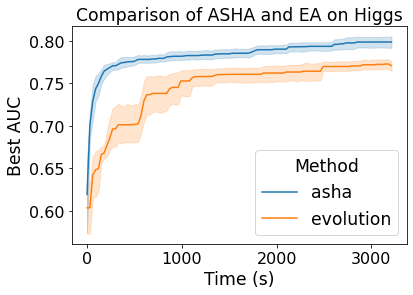

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
seaborn.lineplot(
    data=results,
    x="end_time",
    y="best_so_far",
    hue="method",
    ax=ax,
)
ax.legend(title="Method", fontsize='xx-large', title_fontsize='xx-large')
ax.set_title("Comparison of ASHA and EA on Higgs", size='xx-large')
ax.set_xlabel("Time (s)", size='xx-large')
ax.set_ylabel("Best AUC", size='xx-large')
ax.tick_params(axis='both', which = 'major', labelsize = 16)

In [11]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("comparison.pdf") as f:
    f.savefig(fig, bbox_inches='tight')